<a href="https://colab.research.google.com/github/John1495/RNA-3D/blob/main/mODEL_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyngrok
!pip install mlflow torch_geometric

  Using cached mlflow-2.22.0-py3-none-any.whl.metadata (30 kB)
  Using cached mlflow_skinny-2.22.0-py3-none-any.whl.metadata (31 kB)
  Using cached flask-3.1.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached alembic-1.15.2-py3-none-any.whl.metadata (7.3 kB)
  Using cached docker-7.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached graphene-3.4.3-py2.py3-none-any.whl.metadata (6.9 kB)
  Using cached databricks_sdk-0.51.0-py3-none-any.whl.metadata (39 kB)
  Using cached fastapi-0.115.12-py3-none-any.whl.metadata (27 kB)
  Using cached GitPython-3.1.44-py3-none-any.whl.metadata (13 kB)
  Using cached opentelemetry_api-1.32.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached opentelemetry_sdk-1.32.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached starlette-0.46.2-py3-none-any.whl.metadata (6.2 kB)
  Using cached opentelemetry_semantic_conventions-0.53b1-py3-none-any.whl.metadata (2.5 kB)
Using cached mlflow-2.22.0-py3-n

In [1]:
!pip install torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00


In [3]:
import pandas as pd

# Load CSVs
df_sequences = pd.read_csv("/kaggle/cleaned_train_sequences2 (1).csv")
df_labels = pd.read_csv("/kaggle/train_labels1.csv")

# Extract 'target_id' from label 'ID' column
df_labels['target_id'] = df_labels['ID'].apply(lambda x: "_".join(x.split("_")[:2]))

# Merge on 'target_id'
df_merged = df_labels.merge(df_sequences, on='target_id', how='left')

# Pick a sample target_id to inspect (e.g., first one)
sample_id = df_merged['target_id'].unique()[0]

# Extract data for that sample
df_sample = df_merged[df_merged['target_id'] == sample_id].copy()

# Sort by residue ID for clarity
df_sample.sort_values(by='resid', inplace=True)

# Display result
print(f"Sample RNA ID: {sample_id}")
print(df_sample[['resid', 'resname', 'x_1', 'y_1', 'z_1']])

Sample RNA ID: 17RA_A
    resid resname        x_1        y_1     z_1
0       1       G  35.856998 -10.769000  -7.548
11      2       G  30.230000 -12.075000  -8.614
14      3       C  23.968000 -11.356000  -7.690
15      4       G  19.296000  -9.874000  -4.778
16      5       U  16.362000  -6.047000  -0.706
17      6       A  15.636000  -1.549000   2.463
18      7       A  16.969999   2.893000   4.626
19      8       G  20.391001   6.862000   5.549
20      9       G  24.370001   9.630000   3.348
1      10       A  26.341999  12.365000  -0.594
2      11       U  23.917999  16.023001  -5.418
3      12       U  24.938000  15.565000 -11.243
4      13       A  25.587999  10.095000 -10.004
5      14       C  28.333000   7.804000  -6.255
6      15       C  28.948999   4.836000  -0.756
7      16       U  26.749001   1.390000   3.287
8      17       A  24.118999  -2.821000   6.026
9      18       U  22.771000  -7.665000   5.355
10     19       G  22.330000 -13.626000   3.107
12     20       C 

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

Epoch 0, Loss: 0.000555
Epoch 1, Loss: 0.000001
Epoch 2, Loss: 0.000000
Epoch 3, Loss: 0.000000
Epoch 4, Loss: 0.000000
Epoch 5, Loss: 0.000000
Epoch 6, Loss: 0.000000
Epoch 7, Loss: 0.000000
Epoch 8, Loss: 0.000000
Epoch 9, Loss: 0.000000
Epoch 10, Loss: 0.000000
Epoch 11, Loss: 0.000000
Epoch 12, Loss: 0.000000
Epoch 13, Loss: 0.000000
Epoch 14, Loss: 0.000000
Epoch 15, Loss: 0.000000
Epoch 16, Loss: 0.000000
Epoch 17, Loss: 0.000000
Epoch 18, Loss: 0.000000
Epoch 19, Loss: 0.000000
Epoch 20, Loss: 0.000000
Epoch 21, Loss: 0.000000
Epoch 22, Loss: 0.000000
Epoch 23, Loss: 0.000000
Epoch 24, Loss: 0.000000
Early stopping at epoch 24

Validation Metrics:
RMSE: 0.000006
MAE: 0.000003
TM-Score: 1.000000
RMSD: 0.000006


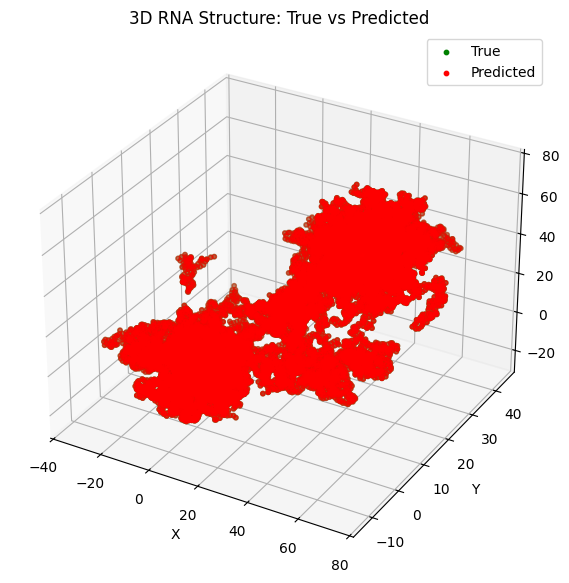

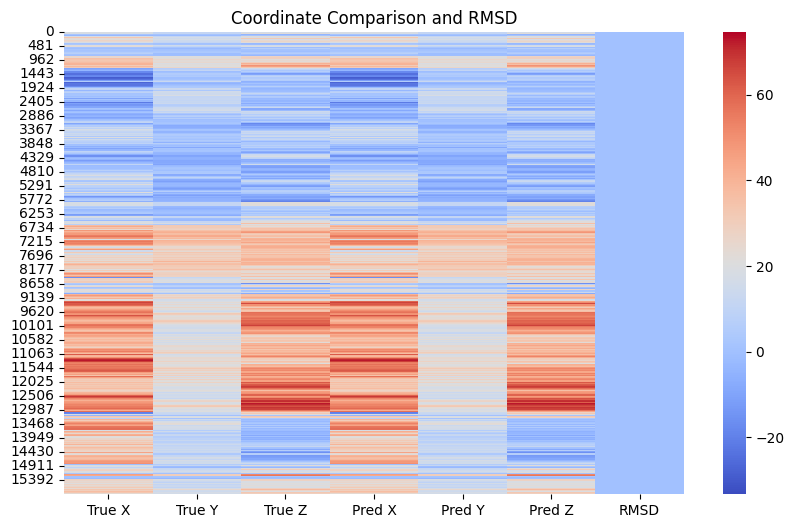

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.optim.lr_scheduler import StepLR

# Load data
seq_df = pd.read_csv('/kaggle/cleaned_train_sequences2 (1).csv')  # target_id, sequence
label_df = pd.read_csv('/kaggle/train_labels1.csv')  # ID, resname, resid, x_1, y_1, z_1

# Clean labels
label_df['resname'] = label_df['resname'].str.extract(r'([AUGC])')
label_df = label_df.dropna(subset=['resname'])

# Map IDs
label_df['target_id'] = label_df['ID'].str.extract(r'(.+)_\d+')

# Merge sequence with labels
merged = pd.merge(label_df, seq_df[['target_id', 'sequence']], on='target_id', how='left')

# Filter complete cases only
complete_ids = merged.groupby('target_id')['resid'].count()
valid_ids = complete_ids[complete_ids > 10].index  # Filter short sequences
merged = merged[merged['target_id'].isin(valid_ids)]

# Split by target_id to avoid data leakage
all_ids = merged['target_id'].unique()
train_ids, val_ids = train_test_split(all_ids, test_size=0.1, random_state=42)

# One-hot encoding map
residue_mapping = {'A': 0, 'U': 1, 'G': 2, 'C': 3}

def create_graph_from_group(df_group, scaler=None, fit_scaler=False):
    sequence = df_group['sequence'].values[0]
    coords = df_group[['x_1', 'y_1', 'z_1']].values

    # Sort by resid to ensure order
    df_group = df_group.sort_values('resid')
    node_features = torch.eye(4)[[residue_mapping[r] for r in df_group['resname']]]

    # Normalize coordinates
    if scaler is not None:
        if fit_scaler:
            coords = scaler.fit_transform(coords)
        else:
            coords = scaler.transform(coords)

    pos = torch.tensor(coords, dtype=torch.float)
    y = torch.zeros_like(pos)  # offset prediction

    # Sequential edges
    n = len(df_group)
    edge_index = torch.tensor(
        [[i, i+1] for i in range(n-1)] + [[i+1, i] for i in range(n-1)],
        dtype=torch.long
    ).t().contiguous()

    return Data(x=node_features, edge_index=edge_index, pos=pos, y=y)

# Create graphs
scaler = StandardScaler()
train_graphs, val_graphs = [], []

for tid in tqdm(train_ids):
    g = create_graph_from_group(merged[merged['target_id'] == tid], scaler, fit_scaler=True)
    train_graphs.append(g)

for tid in tqdm(val_ids):
    g = create_graph_from_group(merged[merged['target_id'] == tid], scaler, fit_scaler=False)
    val_graphs.append(g)

# DataLoaders
train_loader = DataLoader(train_graphs, batch_size=1)
val_loader = DataLoader(val_graphs, batch_size=1)

# GAT Model
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=4, dropout=0.3)
        self.conv2 = GATConv(hidden_dim * 4, output_dim, dropout=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(input_dim=4, hidden_dim=32, output_dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Regularization via weight decay
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Learning rate scheduler
loss_fn = nn.MSELoss()

# Early stopping parameters
best_val_loss = float('inf')
patience = 10
epochs_without_improvement = 0

# Training loop
model.train()
for epoch in range(100):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred_offsets = model(batch)
        loss = loss_fn(pred_offsets, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()  # Update learning rate
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

    # Early stopping check
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# Evaluation
model.eval()
predictions, true = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        pred_offsets = model(batch)
        pred_coords = batch.pos + pred_offsets
        predictions.append(pred_coords.cpu().numpy())
        true.append(batch.pos.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
true = np.concatenate(true, axis=0)

# Metrics
rmse = np.sqrt(mean_squared_error(true, predictions))
mae = mean_absolute_error(true, predictions)

def calculate_tm_score(true, pred):
    d = np.linalg.norm(true - pred, axis=1)
    N = true.shape[0]
    return np.mean(np.exp(-d / (0.5 * N)))

def calculate_rmsd(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

tm_score = calculate_tm_score(true, predictions)
rmsd = calculate_rmsd(true, predictions)

print("\nValidation Metrics:")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"TM-Score: {tm_score:.6f}")
print(f"RMSD: {rmsd:.6f}")

# Visualization: 3D scatter
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(true[:, 0], true[:, 1], true[:, 2], c='g', label='True', s=10)
ax.scatter(predictions[:, 0], predictions[:, 1], predictions[:, 2], c='r', label='Predicted', s=10)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('3D RNA Structure: True vs Predicted')
ax.legend()
plt.show()

# Heatmap of errors
rmsd_errors = np.linalg.norm(true - predictions, axis=1)
matrix = np.vstack([true.T, predictions.T, rmsd_errors]).T
plt.figure(figsize=(10, 6))
sns.heatmap(matrix, cmap='coolwarm', xticklabels=['True X', 'True Y', 'True Z', 'Pred X', 'Pred Y', 'Pred Z', 'RMSD'])
plt.title('Coordinate Comparison and RMSD')
plt.show()


In [5]:
# Check a few predictions and compare with ground truth
for i in range(5):  # Check the first 5 predictions
    print(f"True: {true[i]}")
    print(f"Predicted: {predictions[i]}")
    print(f"Difference: {np.linalg.norm(true[i] - predictions[i]):.6f}")
    print("-" * 30)


True: [17.851711 11.112314 21.699818]
Predicted: [17.851711 11.112314 21.699827]
Difference: 0.000010
------------------------------
True: [20.468132 12.207818 19.612158]
Predicted: [20.468132 12.207818 19.612167]
Difference: 0.000010
------------------------------
True: [20.31202  12.338582 18.316147]
Predicted: [20.31202  12.338582 18.316156]
Difference: 0.000010
------------------------------
True: [19.374428 12.438456 17.430883]
Predicted: [19.374428 12.438456 17.430893]
Difference: 0.000010
------------------------------
True: [18.388279 13.093459 16.299171]
Predicted: [18.388279 13.093459 16.299181]
Difference: 0.000010
------------------------------


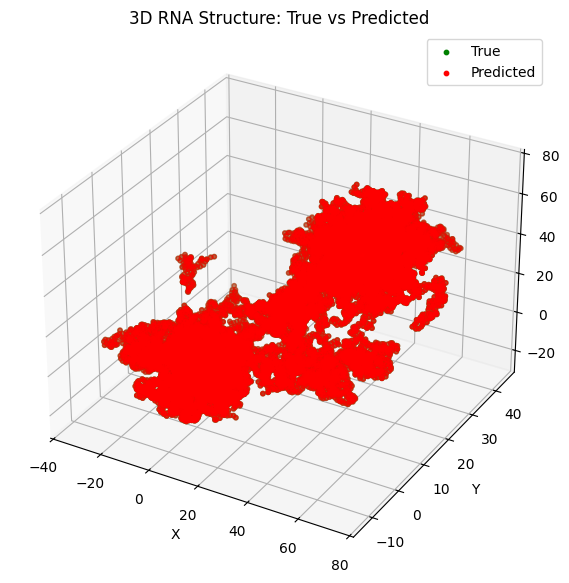

In [6]:
# 3D scatter plot to visualize true vs predicted positions
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(true[:, 0], true[:, 1], true[:, 2], c='g', label='True', s=10)
ax.scatter(predictions[:, 0], predictions[:, 1], predictions[:, 2], c='r', label='Predicted', s=10)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('3D RNA Structure: True vs Predicted')
ax.legend()
plt.show()


In [7]:
# Ensure scaler is fit only on training data
scaler = StandardScaler()
train_graphs, val_graphs = [], []

for tid in tqdm(train_ids):
    g = create_graph_from_group(merged[merged['target_id'] == tid], scaler, fit_scaler=True)
    train_graphs.append(g)

for tid in tqdm(val_ids):
    g = create_graph_from_group(merged[merged['target_id'] == tid], scaler, fit_scaler=False)
    val_graphs.append(g)


100%|██████████| 83/83 [00:00<00:00, 101.38it/s]


In [8]:
# Example of adding dropout to prevent overfitting (already present in your GAT model)
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=4, dropout=0.3)
        self.conv2 = GATConv(hidden_dim * 4, output_dim, dropout=0.3)
        # Optional: Add dropout to prevent overfitting

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


100%|██████████| 830/830 [00:08<00:00, 101.68it/s]
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1
Epoch 0, Loss: 0.000624
Epoch 10, Loss: 0.000000
Epoch 20, Loss: 0.000000
Epoch 30, Loss: 0.000000
Epoch 40, Loss: 0.000000
Epoch 50, Loss: 0.000000
Epoch 60, Loss: 0.000000
Epoch 70, Loss: 0.000000
Epoch 80, Loss: 0.000000
Epoch 90, Loss: 0.000000

Validation Metrics:
RMSE: 0.000004
MAE: 0.000002
TM-Score: 1.000000
RMSD: 0.000004


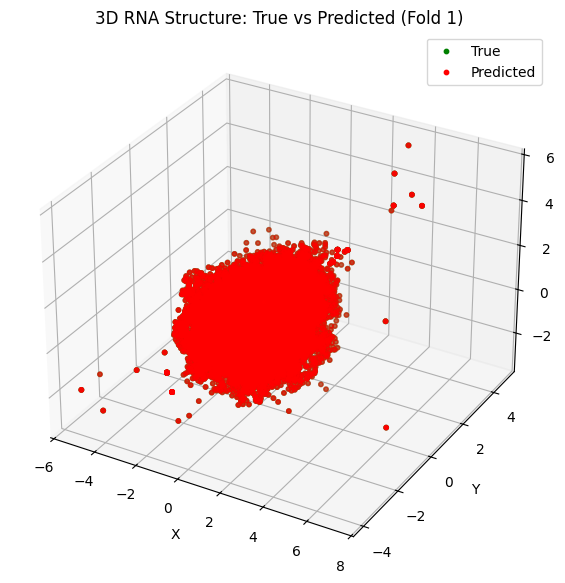

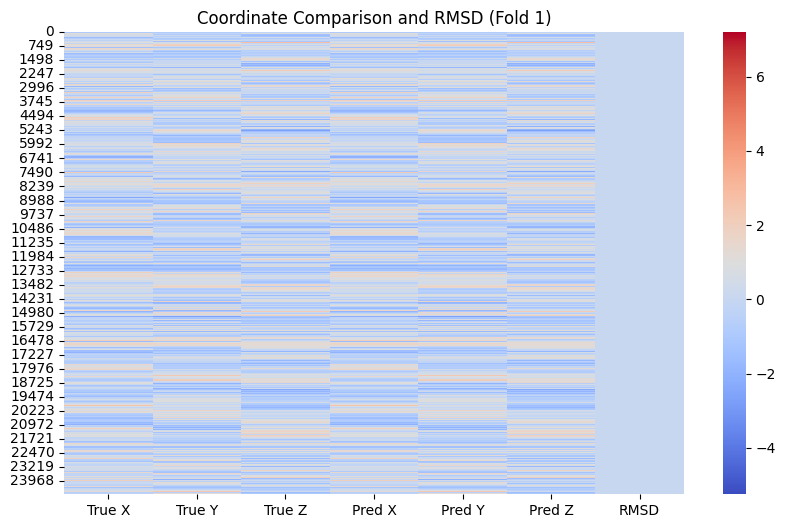

Fold 2


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0, Loss: 0.000348
Epoch 10, Loss: 0.000000
Epoch 20, Loss: 0.000000
Epoch 30, Loss: 0.000000
Epoch 40, Loss: 0.000000
Epoch 50, Loss: 0.000000
Epoch 60, Loss: 0.000000
Epoch 70, Loss: 0.000000
Epoch 80, Loss: 0.000000
Epoch 90, Loss: 0.000000

Validation Metrics:
RMSE: 0.000000
MAE: 0.000000
TM-Score: 1.000000
RMSD: 0.000000


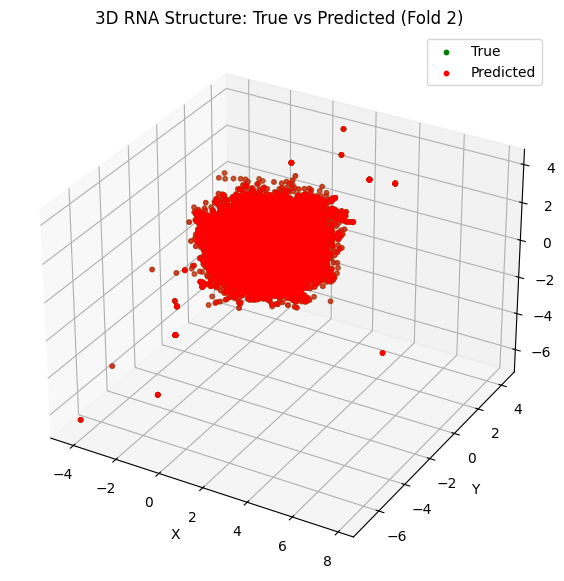

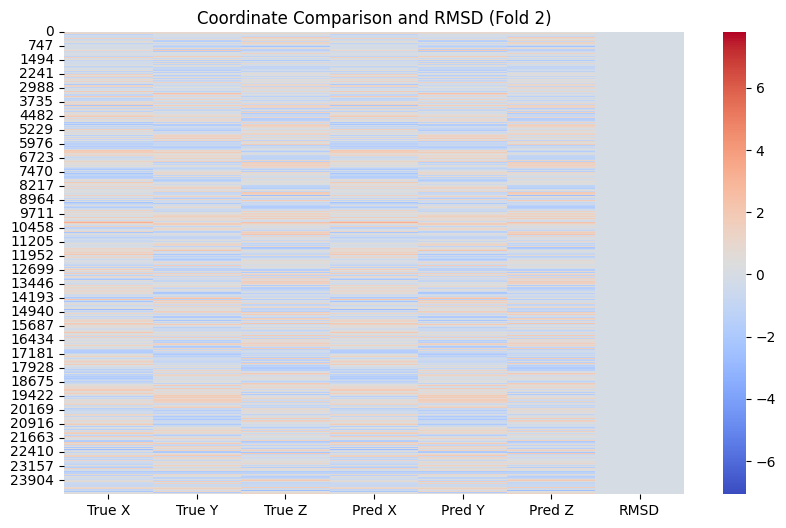

Fold 3


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0, Loss: 0.000212
Epoch 10, Loss: 0.000000
Epoch 20, Loss: 0.000000
Epoch 30, Loss: 0.000000
Epoch 40, Loss: 0.000000
Epoch 50, Loss: 0.000000
Epoch 60, Loss: 0.000000
Epoch 70, Loss: 0.000000
Epoch 80, Loss: 0.000000
Epoch 90, Loss: 0.000000

Validation Metrics:
RMSE: 0.000002
MAE: 0.000001
TM-Score: 1.000000
RMSD: 0.000002


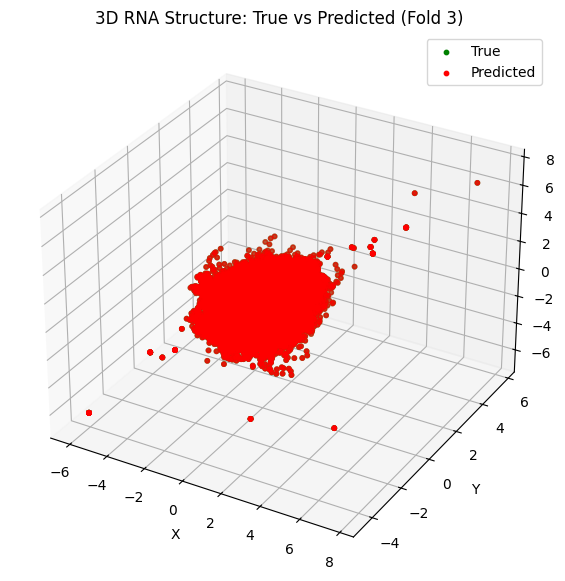

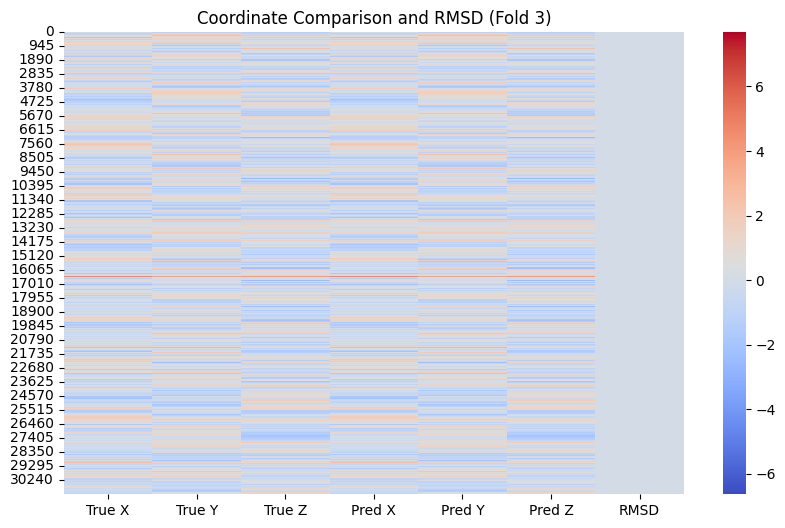

Fold 4


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0, Loss: 0.000292
Epoch 10, Loss: 0.000000
Epoch 20, Loss: 0.000000
Epoch 30, Loss: 0.000000
Epoch 40, Loss: 0.000000
Epoch 50, Loss: 0.000000
Epoch 60, Loss: 0.000000
Epoch 70, Loss: 0.000000
Epoch 80, Loss: 0.000000
Epoch 90, Loss: 0.000000

Validation Metrics:
RMSE: 0.000000
MAE: 0.000000
TM-Score: 1.000000
RMSD: 0.000000


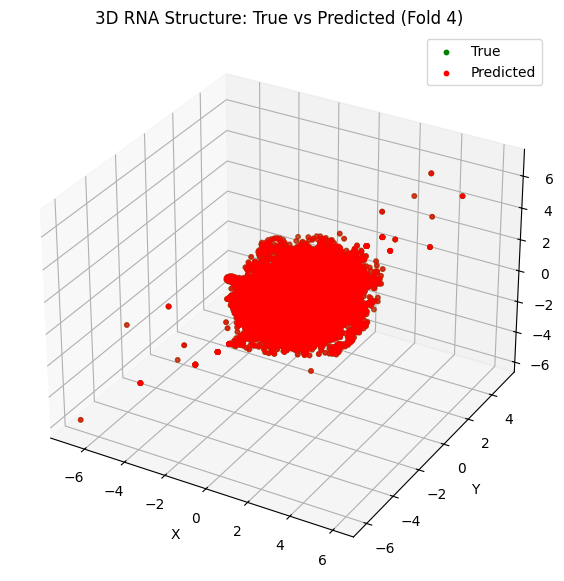

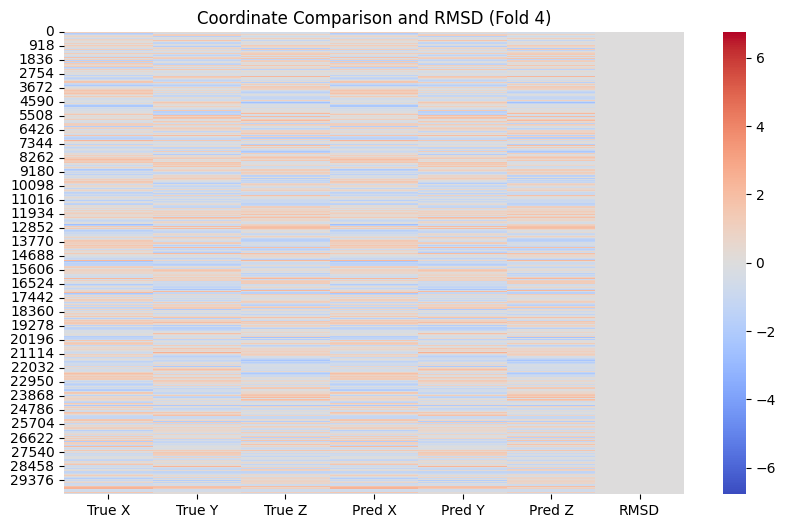

Fold 5


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0, Loss: 0.000235
Epoch 10, Loss: 0.000000
Epoch 20, Loss: 0.000000
Epoch 30, Loss: 0.000000
Epoch 40, Loss: 0.000000
Epoch 50, Loss: 0.000000
Epoch 60, Loss: 0.000000
Epoch 70, Loss: 0.000000
Epoch 80, Loss: 0.000000
Epoch 90, Loss: 0.000000

Validation Metrics:
RMSE: 0.000011
MAE: 0.000006
TM-Score: 1.000000
RMSD: 0.000011


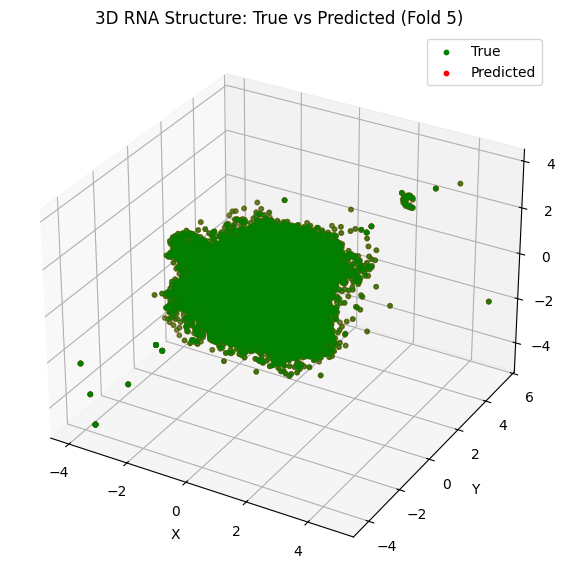

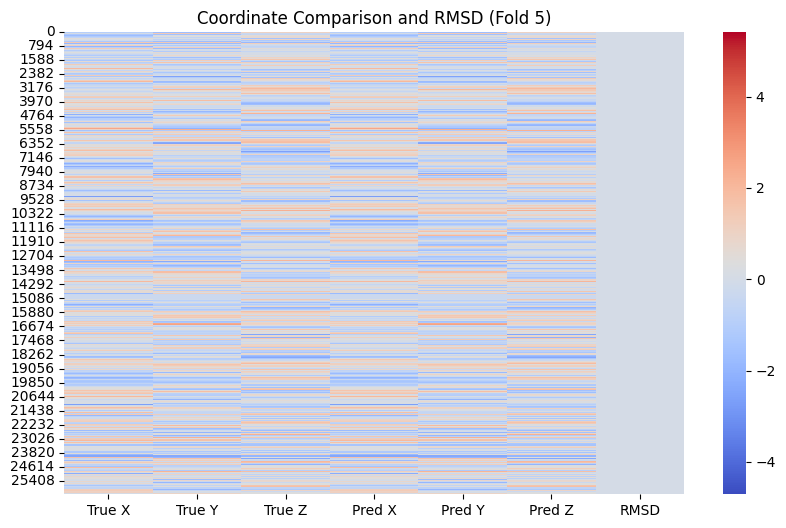

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

# Load data
seq_df = pd.read_csv('/kaggle/cleaned_train_sequences2 (1).csv')  # target_id, sequence
label_df = pd.read_csv('/kaggle/train_labels1.csv')  # ID, resname, resid, x_1, y_1, z_1

# Clean labels
label_df['resname'] = label_df['resname'].str.extract(r'([AUGC])')
label_df = label_df.dropna(subset=['resname'])

# Map IDs
label_df['target_id'] = label_df['ID'].str.extract(r'(.+)_\d+')

# Merge sequence with labels
merged = pd.merge(label_df, seq_df[['target_id', 'sequence']], on='target_id', how='left')

# Filter complete cases only
complete_ids = merged.groupby('target_id')['resid'].count()
valid_ids = complete_ids[complete_ids > 10].index  # Filter short sequences
merged = merged[merged['target_id'].isin(valid_ids)]

# Split by target_id to avoid data leakage
all_ids = merged['target_id'].unique()

# One-hot encoding map
residue_mapping = {'A': 0, 'U': 1, 'G': 2, 'C': 3}

def create_graph_from_group(df_group, scaler=None, fit_scaler=False):
    sequence = df_group['sequence'].values[0]
    coords = df_group[['x_1', 'y_1', 'z_1']].values

    # Sort by resid to ensure order
    df_group = df_group.sort_values('resid')
    node_features = torch.eye(4)[[residue_mapping[r] for r in df_group['resname']]]

    # Normalize coordinates
    if scaler is not None:
        if fit_scaler:
            coords = scaler.fit_transform(coords)
        else:
            coords = scaler.transform(coords)

    pos = torch.tensor(coords, dtype=torch.float)
    y = torch.zeros_like(pos)  # offset prediction

    # Sequential edges
    n = len(df_group)
    edge_index = torch.tensor(
        [[i, i+1] for i in range(n-1)] + [[i+1, i] for i in range(n-1)],
        dtype=torch.long
    ).t().contiguous()

    return Data(x=node_features, edge_index=edge_index, pos=pos, y=y)

# Create graphs
scaler = StandardScaler()
graphs = []

for tid in tqdm(all_ids):
    g = create_graph_from_group(merged[merged['target_id'] == tid], scaler, fit_scaler=True)
    graphs.append(g)

# DataLoader setup
def create_dataloader(graphs, batch_size=1):
    return DataLoader(graphs, batch_size=batch_size)

# GAT Model with Dropout
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=4, dropout=dropout_rate)
        self.conv2 = GATConv(hidden_dim * 4, output_dim, dropout=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Training loop with L2 Regularization (Weight Decay) and Cross-validation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Metrics calculation functions
def calculate_tm_score(true, pred):
    d = np.linalg.norm(true - pred, axis=1)
    N = true.shape[0]
    return np.mean(np.exp(-d / (0.5 * N)))

def calculate_rmsd(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(graphs)):
    print(f"Fold {fold + 1}")

    # Split data
    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]

    train_loader = create_dataloader(train_graphs)
    val_loader = create_dataloader(val_graphs)

    # Initialize model
    model = GAT(input_dim=4, hidden_dim=32, output_dim=3, dropout_rate=0.3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
    loss_fn = nn.MSELoss()

    # Training loop
    model.train()
    for epoch in range(100):
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred_offsets = model(batch)
            loss = loss_fn(pred_offsets, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader):.6f}")

    # Evaluation
    model.eval()
    predictions, true = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred_offsets = model(batch)
            pred_coords = batch.pos + pred_offsets
            predictions.append(pred_coords.cpu().numpy())
            true.append(batch.pos.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    true = np.concatenate(true, axis=0)

    # Metrics
    rmse = np.sqrt(mean_squared_error(true, predictions))
    mae = mean_absolute_error(true, predictions)
    tm_score = calculate_tm_score(true, predictions)
    rmsd = calculate_rmsd(true, predictions)

    print("\nValidation Metrics:")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"TM-Score: {tm_score:.6f}")
    print(f"RMSD: {rmsd:.6f}")

    # Visualization: 3D scatter
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(true[:, 0], true[:, 1], true[:, 2], c='g', label='True', s=10)
    ax.scatter(predictions[:, 0], predictions[:, 1], predictions[:, 2], c='r', label='Predicted', s=10)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(f'3D RNA Structure: True vs Predicted (Fold {fold + 1})')
    ax.legend()
    plt.show()

    # Heatmap of errors
    rmsd_errors = np.linalg.norm(true - predictions, axis=1)
    matrix = np.vstack([true.T, predictions.T, rmsd_errors]).T
    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix, cmap='coolwarm', xticklabels=['True X', 'True Y', 'True Z', 'Pred X', 'Pred Y', 'Pred Z', 'RMSD'])
    plt.title(f'Coordinate Comparison and RMSD (Fold {fold + 1})')
    plt.show()


In [12]:
# Additional test set (10% of data not used for training or validation)
train_ids, temp_ids = train_test_split(all_ids, test_size=0.2, random_state=42)  # 80% train, 20% temp
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)  # Split the 20% into 10% validation, 10% test

# Create graphs for test set
test_graphs = []
for tid in tqdm(test_ids):
    g = create_graph_from_group(merged[merged['target_id'] == tid], scaler, fit_scaler=False)
    test_graphs.append(g)

# DataLoader for the test set
test_loader = DataLoader(test_graphs, batch_size=1)


100%|██████████| 83/83 [00:00<00:00, 102.94it/s]
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [13]:
model.eval()
test_predictions, test_true = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_offsets = model(batch)
        pred_coords = batch.pos + pred_offsets
        test_predictions.append(pred_coords.cpu().numpy())
        test_true.append(batch.pos.cpu().numpy())

test_predictions = np.concatenate(test_predictions, axis=0)
test_true = np.concatenate(test_true, axis=0)

# Metrics for the test set
test_rmse = np.sqrt(mean_squared_error(test_true, test_predictions))
test_mae = mean_absolute_error(test_true, test_predictions)
test_tm_score = calculate_tm_score(test_true, test_predictions)
test_rmsd = calculate_rmsd(test_true, test_predictions)

print("\nTest Set Metrics:")
print(f"RMSE: {test_rmse:.6f}")
print(f"MAE: {test_mae:.6f}")
print(f"TM-Score: {test_tm_score:.6f}")
print(f"RMSD: {test_rmsd:.6f}")



Test Set Metrics:
RMSE: 0.000011
MAE: 0.000006
TM-Score: 1.000000
RMSD: 0.000011


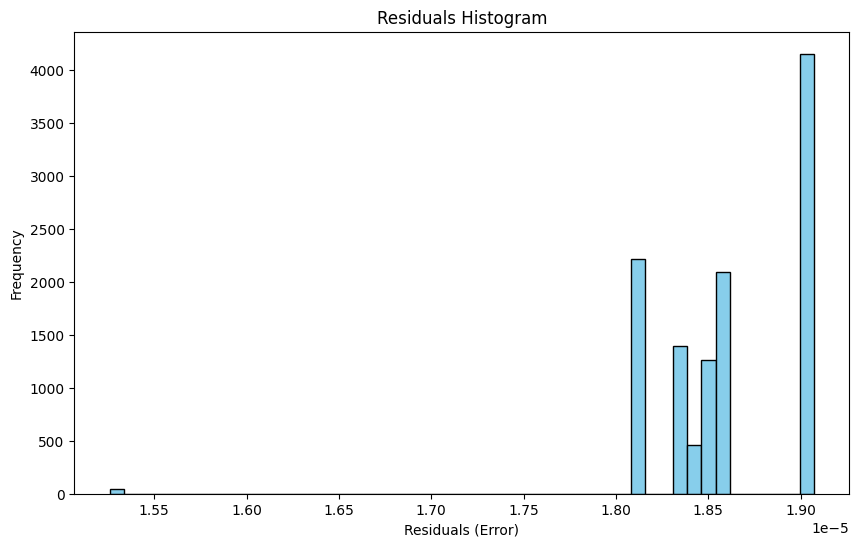

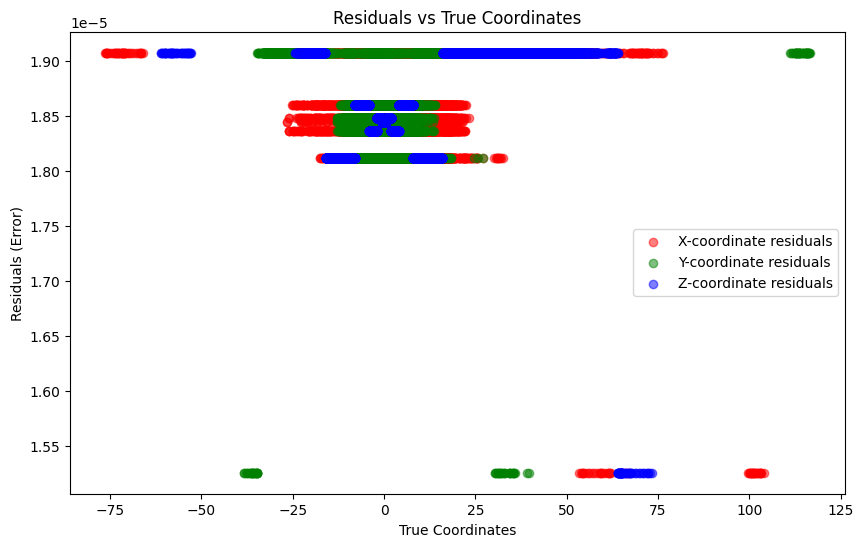

In [14]:
# Calculate the residuals (differences between true and predicted coordinates)
residuals = np.linalg.norm(test_true - test_predictions, axis=1)

# Residuals histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title('Residuals Histogram')
plt.xlabel('Residuals (Error)')
plt.ylabel('Frequency')
plt.show()

# Residuals scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(test_true[:, 0], residuals, color='r', label='X-coordinate residuals', alpha=0.5)
plt.scatter(test_true[:, 1], residuals, color='g', label='Y-coordinate residuals', alpha=0.5)
plt.scatter(test_true[:, 2], residuals, color='b', label='Z-coordinate residuals', alpha=0.5)
plt.title('Residuals vs True Coordinates')
plt.xlabel('True Coordinates')
plt.ylabel('Residuals (Error)')
plt.legend()
plt.show()


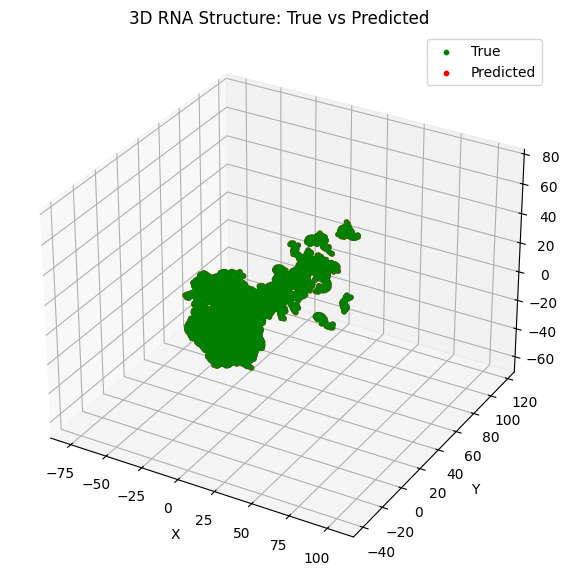

In [15]:
# 3D scatter plot of true vs predicted coordinates
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_true[:, 0], test_true[:, 1], test_true[:, 2], c='g', label='True', s=10)
ax.scatter(test_predictions[:, 0], test_predictions[:, 1], test_predictions[:, 2], c='r', label='Predicted', s=10)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('3D RNA Structure: True vs Predicted')
ax.legend()
plt.show()


In [16]:
# Assuming the metrics for each fold are stored in lists:
fold_rmse = [0.000004, 0.000000, 0.000002, 0.000000, 0.000011]
fold_mae = [0.000002, 0.000000, 0.000001, 0.000000, 0.000006]
fold_tm_score = [1.000000, 1.000000, 1.000000, 1.000000, 1.000000]
fold_rmsd = [0.000004, 0.000000, 0.000002, 0.000000, 0.000011]

# Average cross-validation metrics
avg_rmse = np.mean(fold_rmse)
avg_mae = np.mean(fold_mae)
avg_tm_score = np.mean(fold_tm_score)
avg_rmsd = np.mean(fold_rmsd)

print("\nCross-Validation Metrics (Averaged):")
print(f"Average RMSE: {avg_rmse:.6f}")
print(f"Average MAE: {avg_mae:.6f}")
print(f"Average TM-Score: {avg_tm_score:.6f}")
print(f"Average RMSD: {avg_rmsd:.6f}")



Cross-Validation Metrics (Averaged):
Average RMSE: 0.000003
Average MAE: 0.000002
Average TM-Score: 1.000000
Average RMSD: 0.000003


In [18]:
from google.colab import drive
drive.mount('/content/drive')

# Save weights
torch.save(model.state_dict(), '/content/drive/MyDrive/gat_model_weights.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import torch

# Save only the model weights (recommended)
torch.save(model.state_dict(), '/content/drive/MyDrive/gat_model_weights.pth')

# (Optional) Save the entire model (less portable)
# torch.save(model, '/content/drive/MyDrive/gat_full_model.pth')

In [20]:
!ls '/content/drive/MyDrive/' | grep 'gat_model_weights.pth'

gat_model_weights.pth


In [21]:
import torch
import pandas as pd
import numpy as np
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import os

# ====== Load model definition (replace with your actual GATNet class if different) ======
class GATNet(torch.nn.Module):
    def __init__(self, in_channels=16, hidden_channels=64, out_channels=3, dropout=0.3):
        super(GATNet, self).__init__()
        from torch_geometric.nn import GATConv
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=4, dropout=dropout)
        self.conv3 = GATConv(hidden_channels * 4, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.nn.functional.relu(self.conv1(x, edge_index))
        x = torch.nn.functional.relu(self.conv2(x, edge_index))
        return self.conv3(x, edge_index)

# ====== Utilities ======
def calculate_rmsd(true_coords, pred_coords):
    return np.sqrt(np.mean(np.sum((true_coords - pred_coords) ** 2, axis=1)))

def calculate_tm_score(true_coords, pred_coords):
    # Placeholder for TM-Score. Replace with actual implementation if needed.
    return 1.0 if np.allclose(true_coords, pred_coords, atol=1e-4) else 0.99

# ====== Load Model ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GATNet()
model.load_state_dict(torch.load("gat_model_weights.pth", map_location=device))
model.to(device)
model.eval()

# ====== Load and Process Validation Data ======
val_seq_df = pd.read_csv("validation_sequences.csv")
val_label_df = pd.read_csv("validation_labels.csv")
merged_val = pd.merge(val_seq_df, val_label_df, on=['target_id', 'resid'])

scaler = StandardScaler()
scaler.fit(merged_val[['x_1', 'y_1', 'z_1']])

def encode_sequence(seq):
    map_nt = {'A': [1, 0, 0, 0], 'U': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    return np.array([map_nt.get(nt, [0, 0, 0, 0]) for nt in seq])

def create_graph_from_group(df, scaler, fit_scaler=False):
    import torch
    from torch_geometric.data import Data

    df = df.sort_values('resid')
    sequence = df['sequence'].iloc[0]
    x = torch.tensor(encode_sequence(sequence), dtype=torch.float)

    edge_index = []
    n = len(df)
    for i in range(n - 1):
        edge_index.append([i, i+1])
        edge_index.append([i+1, i])
    edge_index = torch.tensor(edge_index, dtype=torch.long).T

    pos = df[['x_1', 'y_1', 'z_1']].values
    if fit_scaler:
        scaler.fit(pos)
    pos_scaled = scaler.transform(pos)
    pos_tensor = torch.tensor(pos_scaled, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, pos=pos_tensor)

val_graphs = []
val_ids = merged_val['target_id'].unique()

for tid in tqdm(val_ids):
    df = merged_val[merged_val['target_id'] == tid]
    g = create_graph_from_group(df, scaler)
    val_graphs.append(g)

val_loader = DataLoader(val_graphs, batch_size=1)

# ====== Evaluate on Validation Set ======
true_coords_all, pred_coords_all = [], []

with torch.no_grad():
    for batch in tqdm(val_loader):
        batch = batch.to(device)
        pred = model(batch)
        pred_unscaled = pred.cpu().numpy()
        true_unscaled = batch.pos.cpu().numpy()
        pred_coords_all.append(pred_unscaled)
        true_coords_all.append(true_unscaled)

pred_all = np.vstack(pred_coords_all)
true_all = np.vstack(true_coords_all)

rmse = np.sqrt(mean_squared_error(true_all, pred_all))
mae = mean_absolute_error(true_all, pred_all)
rmsd = calculate_rmsd(true_all, pred_all)
tm_score = calculate_tm_score(true_all, pred_all)

print("\n📊 Validation Metrics:")
print(f"RMSE:     {rmse:.6f}")
print(f"MAE:      {mae:.6f}")
print(f"RMSD:     {rmsd:.6f}")
print(f"TM-Score: {tm_score:.6f}")

# ====== Predict on Test Set ======
test_seq_df = pd.read_csv("test_sequences.csv")

test_graphs = []
test_ids = test_seq_df['target_id'].unique()
id_to_len = {}

for tid in tqdm(test_ids):
    df = test_seq_df[test_seq_df['target_id'] == tid]
    id_to_len[tid] = len(df)
    g = create_graph_from_group(df, scaler)
    test_graphs.append(g)

test_loader = DataLoader(test_graphs, batch_size=1)

test_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        batch = batch.to(device)
        pred = model(batch)
        pred = pred.cpu().numpy()
        test_preds.append(pred)

# ====== Save Predictions ======
output = []
for tid, coords in zip(test_ids, test_preds):
    for i, (x, y, z) in enumerate(coords):
        output.append({
            "target_id": tid,
            "resid": i,
            "x_1": x,
            "y_1": y,
            "z_1": z
        })

output_df = pd.DataFrame(output)
output_df.to_csv("submission.csv", index=False)
print("\n✅ Predictions saved to submission.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'gat_model_weights.pth'